# Generative Adversarial Networks #
 * Discrement Models
    - Classification
    - $ Feature(X) → Class(Y) $ or $ P(Y|X)$
 * Generative Models
    - $Noise(\xi), Class (Y) → Features (X)$ or $P(X|Y)$
 * Generator → Discriminator
   - Generator learns to make fake that looks real
   - Discriminator learns to distinquish real from fake
      * Classifiers

 * Binary Cross Entropy
   - $ J\left(\theta\right)=-\frac{1}{m}\sum_{i=1}^{m}\left[y^{(i)}\log{h(x^{\left(i\right)},\theta)}+\left(1-y^{\left(i\right)}\right)\log(1-h(x^{\left(i\right)},\theta))\right] $
   
   

In [ ]:
import math
import torch
from torchvision import datasets, transforms
from torchvision.datasets import CIFAR10
from torchvision.datasets import MNIST 
import matplotlib.pyplot as plt
from torch import nn, optim
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from IPython.display import display, clear_output, Image as IPyImage
import io
import imageio

# Define transforms
transform_mnist = transforms.Compose([
    transforms.ToTensor()
])

transform_cifar = transforms.Compose([
    transforms.ToTensor()
])

# Load datasets
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
cifar10_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)

# Get class names
mnist_classes = [str(i) for i in range(10)]
cifar10_classes = cifar10_dataset.classes

Files already downloaded and verified


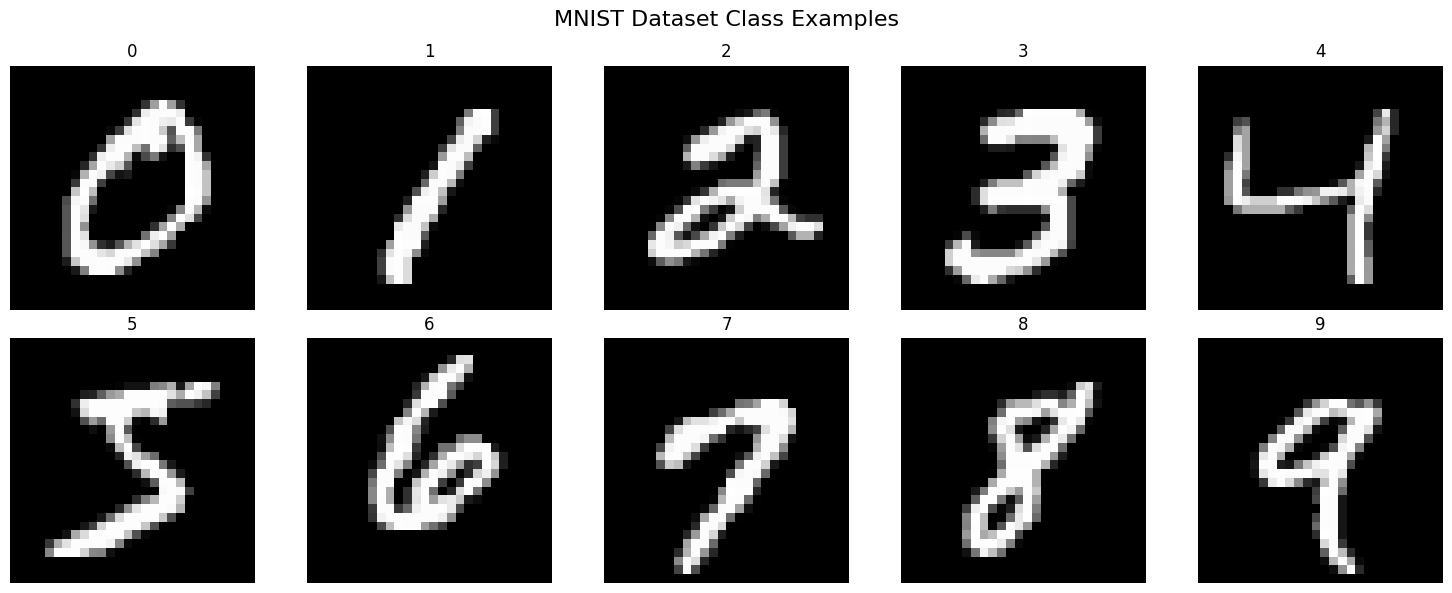

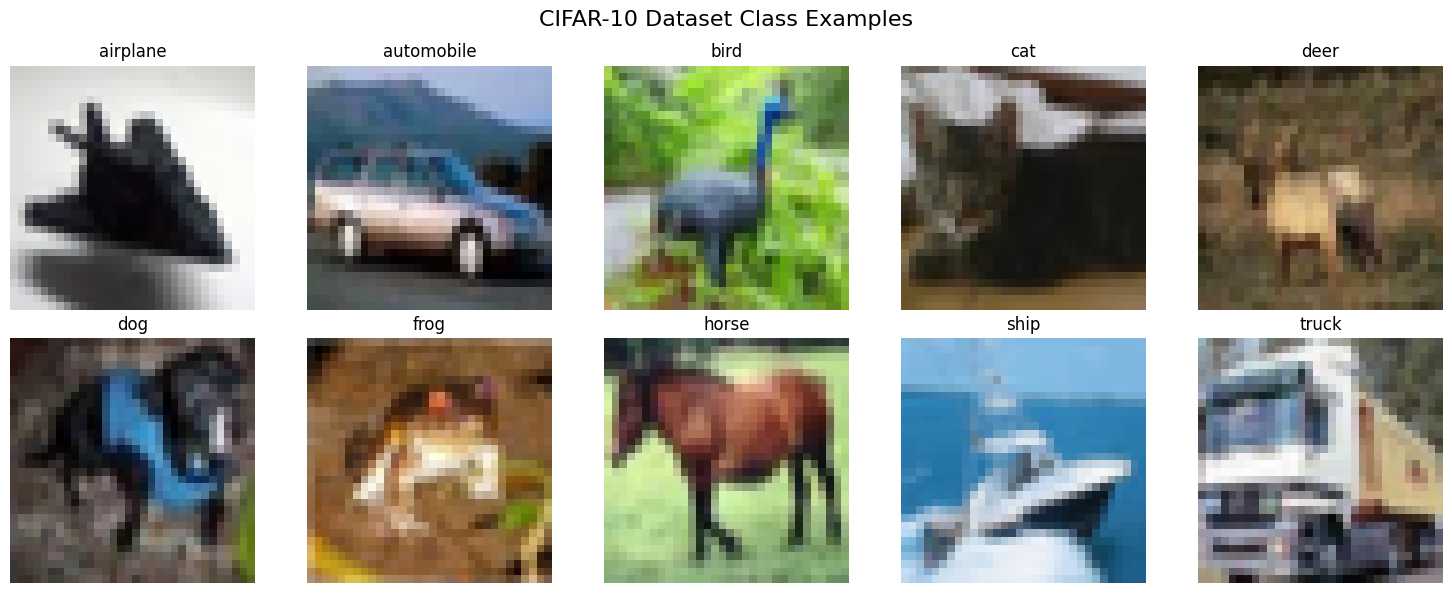

In [ ]:
# Function to find one example per class from a dataset
def get_examples_per_class(dataset, num_classes):
    examples = [None] * num_classes
    for image, label in dataset:
        if examples[label] is None:
            examples[label] = (image, label)
        if all(example is not None for example in examples):
            break
    return examples

# Get one example per class for MNIST and CIFAR-10
mnist_examples = get_examples_per_class(mnist_dataset, len(mnist_classes))
cifar10_examples = get_examples_per_class(cifar10_dataset, len(cifar10_classes))

# Function to plot examples with a max of 5 per row
def plot_examples(examples, class_names, title, cmap=None, permute=False):
    n = len(examples)
    cols = 5
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    fig.suptitle(title, fontsize=16)
    
    # Flatten axes for easy iteration (works whether axes is 1D or 2D)
    if rows == 1:
        axes = axes.flatten() if isinstance(axes, list) else [axes]
    else:
        axes = axes.flatten()
        
    for i, (image, label) in enumerate(examples):
        ax = axes[i]
        if permute:
            ax.imshow(image.permute(1, 2, 0))
        else:
            ax.imshow(image.squeeze(), cmap=cmap)
        ax.set_title(class_names[label])
        ax.axis('off')
    
    # Turn off any extra subplots if they exist
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot examples for MNIST (grayscale)
plot_examples(mnist_examples, mnist_classes, 'MNIST Dataset Class Examples', cmap='gray')

# Plot examples for CIFAR-10 (color)
plot_examples(cifar10_examples, cifar10_classes, 'CIFAR-10 Dataset Class Examples', permute=True)

Training GIF saved as training.gif with duration ~10 seconds


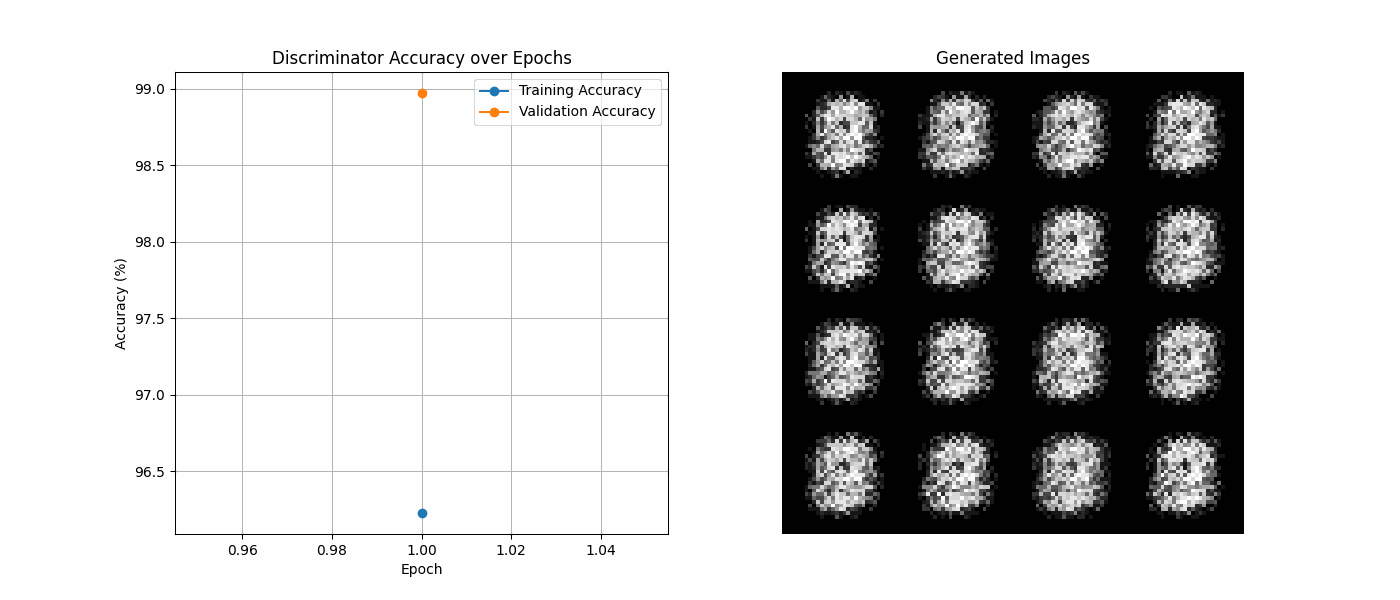

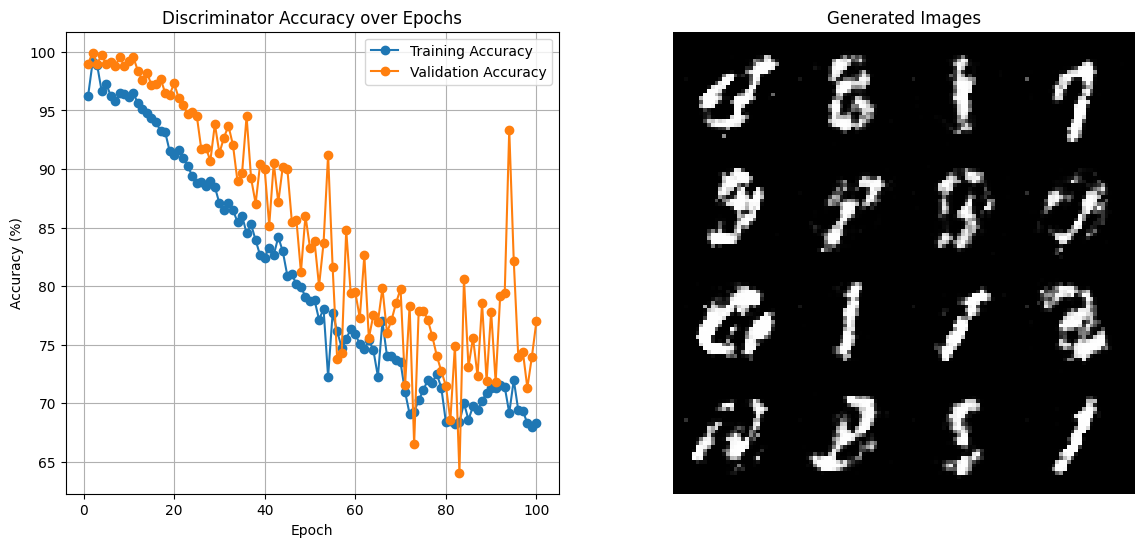

In [ ]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CIFAR-10 image parameters
image_size = 32
image_size = 28
channels = 3  # CIFAR-10 images are RGB
channels = 1
image_dim = channels * image_size * image_size  # 3 x 32 x 32 = 3072

# Hyperparameters and setup
batch_size = 128
epochs = 100
learning_rate = 0.0002
noise_dim = 100          # Dimension for the noise vector
num_images = batch_size  # Number of images per batch

# Desired total duration of the output GIF (in seconds)
t = 10  # For example, 10 seconds

class GAN():
    """
    Conventional GAN class that builds a generator and discriminator.
    """
    def __init__(self, noise_dim, image_dim, numImages):
        self.image_dim = image_dim
        self.noise_dim = noise_dim
        self.numImages = numImages
        self.generator = None
        self.discriminator = None

    def noiseMatrix(self, n_samples):
        return torch.randn(n_samples, self.noise_dim, device=device)
    
    def initGenerator(self):
        # A simple fully connected network for CIFAR-10.
        self.generator = nn.Sequential(
            nn.Linear(self.noise_dim, self.noise_dim * 2),
            nn.BatchNorm1d(self.noise_dim * 2),
            nn.ReLU(inplace=True),
            nn.Linear(self.noise_dim * 2, self.noise_dim),
            nn.BatchNorm1d(self.noise_dim),
            nn.ReLU(inplace=True),
            nn.Linear(self.noise_dim, self.image_dim),
            nn.Sigmoid()
        ).to(device)

    def initDiscriminator(self):
        # A simple fully connected network with dropout for regularization.
        self.discriminator = nn.Sequential(
            nn.Linear(self.image_dim, self.noise_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(self.noise_dim, self.noise_dim // 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(self.noise_dim // 2, 1)
        ).to(device)

    def forwardGenerator(self, noise):
        return self.generator(noise)

    def forwardDiscriminator(self, images):
        return self.discriminator(images)

    def lossGenerator(self, batch_size):
        noise = self.noiseMatrix(batch_size)
        fake_images = self.forwardGenerator(noise)
        disc_result = self.forwardDiscriminator(fake_images)
        # Generator wants discriminator to think fake images are real (target=1)
        real_target = torch.ones(batch_size, 1, device=device)
        criterion = nn.BCEWithLogitsLoss()
        return criterion(disc_result, real_target)

    def lossDiscriminator(self, real_images, batch_size):
        noise = self.noiseMatrix(batch_size)
        fake_images = self.forwardGenerator(noise).detach()
        real_target = torch.ones(batch_size, 1, device=device)
        fake_target = torch.zeros(batch_size, 1, device=device)
        criterion = nn.BCEWithLogitsLoss()
        loss_real = criterion(self.forwardDiscriminator(real_images), real_target)
        loss_fake = criterion(self.forwardDiscriminator(fake_images), fake_target)
        return (loss_real + loss_fake) / 2

def compute_accuracy(discriminator, real_images, batch_size):
    # Accuracy on real images
    disc_real = discriminator(real_images)
    real_preds = (torch.sigmoid(disc_real) >= 0.5).float()
    real_acc = real_preds.mean().item()  # target is 1 for real images

    # Accuracy on fake images
    noise = torch.randn(batch_size, gan.noise_dim, device=device)
    fake_images = gan.forwardGenerator(noise).detach()
    disc_fake = discriminator(fake_images)
    fake_preds = (torch.sigmoid(disc_fake) < 0.5).float()
    fake_acc = fake_preds.mean().item()  # target is 0 for fake images

    # Combined accuracy (average of both)
    return (real_acc + fake_acc) / 2

# Transform: convert CIFAR-10 images to tensor and flatten to a vector.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

# Load CIFAR-10 dataset (train and test as validation)
# train_dataset = CIFAR10(root='./data', train=True, transform=transform, download=True)
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# val_dataset = CIFAR10(root='./data', train=False, transform=transform, download=True)
val_dataset = MNIST(root='./data', train=False, transform=transform, download=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize GAN
gan = GAN(noise_dim, image_dim, num_images)
gan.initGenerator()
gan.initDiscriminator()

optimizer_G = optim.Adam(gan.generator.parameters(), lr=learning_rate)
optimizer_D = optim.Adam(gan.discriminator.parameters(), lr=learning_rate)

# For recording frames for the GIF (one frame per epoch)
frames = []
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Lists to store epoch-wise accuracy for plotting
train_acc_epochs = []
val_acc_epochs = []
epochs_list = []

# Training loop
for epoch in range(epochs):
    gan.generator.train()
    gan.discriminator.train()
    epoch_train_acc = 0
    num_batches = 0

    for i, (images, _) in enumerate(train_loader):
        real_images = images.to(device)
        current_batch_size = real_images.size(0)
        
        # Update Discriminator
        optimizer_D.zero_grad()
        d_loss = gan.lossDiscriminator(real_images, current_batch_size)
        d_loss.backward()
        optimizer_D.step()
        
        # Compute training accuracy for this batch
        batch_acc = compute_accuracy(gan.discriminator, real_images, current_batch_size)
        epoch_train_acc += batch_acc
        num_batches += 1
        
        # Update Generator
        optimizer_G.zero_grad()
        g_loss = gan.lossGenerator(current_batch_size)
        g_loss.backward()
        optimizer_G.step()
        
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] Batch {i}/{len(train_loader)} "
                  f"Loss D: {d_loss.item():.4f}, Loss G: {g_loss.item():.4f}, "
                  f"Batch Acc: {batch_acc:.4f}")

    # Average training accuracy for this epoch
    avg_train_acc = epoch_train_acc / num_batches
    train_acc_epochs.append(avg_train_acc * 100)  # as percentage
    epochs_list.append(epoch + 1)
    
    # Compute validation accuracy over the entire validation set
    gan.discriminator.eval()
    val_acc_total = 0
    val_batches = 0
    with torch.no_grad():
        for images, _ in val_loader:
            images = images.to(device)
            current_batch_size = images.size(0)
            val_acc_total += compute_accuracy(gan.discriminator, images, current_batch_size)
            val_batches += 1
    avg_val_acc = val_acc_total / val_batches
    val_acc_epochs.append(avg_val_acc * 100)  # as percentage
    
    print(f"Epoch [{epoch+1}/{epochs}] Training Accuracy: {avg_train_acc:.4f}, Validation Accuracy: {avg_val_acc:.4f}")

    # Generate images for display
    gan.generator.eval()
    with torch.no_grad():
        noise = gan.noiseMatrix(16)
        fake_images = gan.forwardGenerator(noise)
        # Reshape generated flat vector into (batch, channels, height, width)
        fake_images = fake_images.view(-1, channels, image_size, image_size).cpu()
    grid = make_grid(fake_images, nrow=4, normalize=True)

    # Update the two-panel figure:
    # Left subplot: plot accuracy vs. epoch.
    ax1.clear()
    ax1.plot(epochs_list, train_acc_epochs, label="Training Accuracy", marker="o")
    ax1.plot(epochs_list, val_acc_epochs, label="Validation Accuracy", marker="o")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy (%)")
    ax1.set_title("Discriminator Accuracy over Epochs")
    ax1.legend()
    ax1.grid(True)
    
    # Right subplot: show grid of generated images.
    ax2.clear()
    ax2.imshow(grid.permute(1, 2, 0).squeeze(), cmap="gray")
    ax2.set_title("Generated Images")
    ax2.axis("off")
    
    display(fig)
    clear_output(wait=True)
    
    # Save current figure to a buffer and append to frames for the GIF
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    frame = imageio.imread(buf)
    frames.append(frame)
    buf.close()

# Calculate fps so that the final GIF duration is approximately t seconds
fps = len(frames) / t
gif_filename = 'training.gif'
imageio.mimsave(gif_filename, frames, fps=fps)
print(f"Training GIF saved as {gif_filename} with duration ~{t} seconds")

# Display the generated GIF
display(IPyImage(filename=gif_filename))
